In [1]:
import os
from pathlib import Path
import pickle

os.environ['ARTEFACT_DIR'] = '/home/hylke/digits_more_topics'


import jax
from jax.tree_util import tree_map
from matplotlib import pyplot as plt
from mubelnet.random import PRNGSequence
from mubelnet.utils import perplexity
import numpy as np

from dataset import load_digits


# Training hyperparameters
RANDOM_SEED = 42
key_seq = PRNGSequence(jax.random.PRNGKey(RANDOM_SEED))


# Model hyperparameters.
MODEL = "multinomial_dirichlet_believe"
n_topics = 10
HIDDEN_LAYER_SIZES = (n_topics, 2 * n_topics, 3 * n_topics)
GAMMA_0 = 1.0
ETA = 0.05
_bottom_layer_name = (
    f"{MODEL}/~/multinomial_layer"
    if MODEL == "multinomial_dirichlet_believe"
    else f"{MODEL}/~/poisson_layer"
)

X_train, X_test = load_digits()
n_features = X_train.shape[1]

2024-01-26 10:41:52.608620: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-26 10:41:52.609012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-26 10:41:52.669115: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-26 10:41:59.942993: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
def probability(params, state):
    bottom_params = params.get(_bottom_layer_name, {})
    bottom_state = state[_bottom_layer_name]
    phi = bottom_params.get("phi", bottom_state.get("phi"))
    theta = bottom_state["copy[theta(1)]"]
    probs = theta @ phi
    probs /= probs.sum(axis=-1, keepdims=True)
    return probs


def evaluate(params, states, X, axis=[0, 1]):
    """Compute perplexity over chains and samples by default (axis=[0, 1])."""
    probs = probability(params, states).mean(axis)
    return perplexity(X, probs)

In [2]:
def load_trace(pkl_path: Path, thin: int = 1):
    with open(pkl_path, 'rb') as fi:
        trace_10_10_10 = pickle.load(fi)
    t_10_10_10 = tree_map(lambda x: x[:, ::thin], trace_10_10_10)
    del trace_10_10_10
    trace_10_10_10 = t_10_10_10
    return trace_10_10_10

In [3]:
trace = load_trace(Path('/home/hylke/digits_more_topics/multinomial_belief/10-20-30/samples/sample_1000.pkl'))

In [4]:
# For each chain, take average over posterior samples.
r = np.mean(trace['multinomial_belief/~/cap_layer']['r'], axis=[1])
phi_1st_layer = np.mean(trace['multinomial_belief/~/multinomial_layer']['phi'], axis=[1])
phi_2nd_layer = np.mean(trace['multinomial_belief/~/dirichlet_layer_1']['phi'], axis=[1])
phi_3rd_layer = np.mean(trace['multinomial_belief/~/dirichlet_layer']['phi'], axis=[1])

In [5]:
p_31 = (phi_3rd_layer @ phi_2nd_layer @ phi_1st_layer).squeeze()
p_21 = (phi_2nd_layer @ phi_1st_layer).squeeze()
p_1 = phi_1st_layer

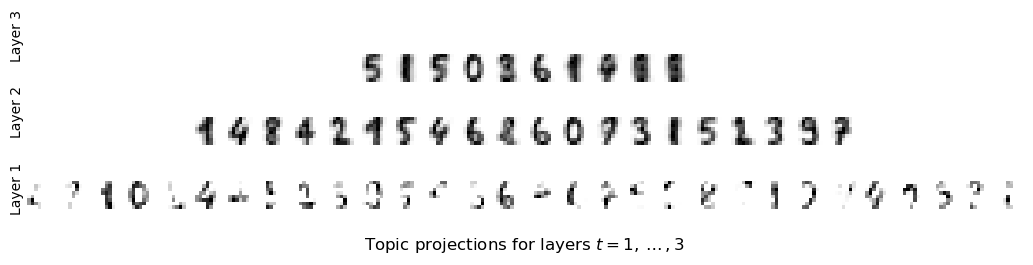

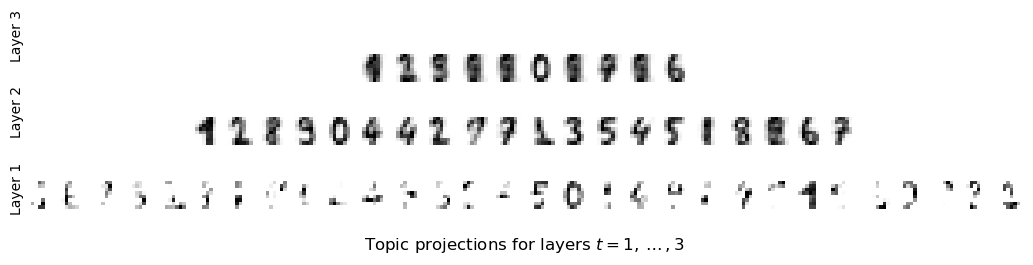

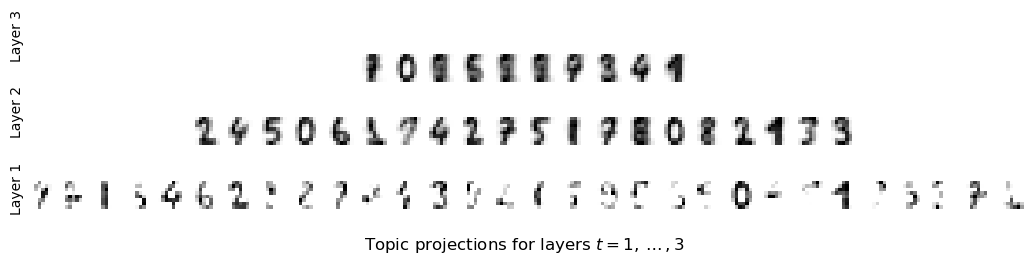

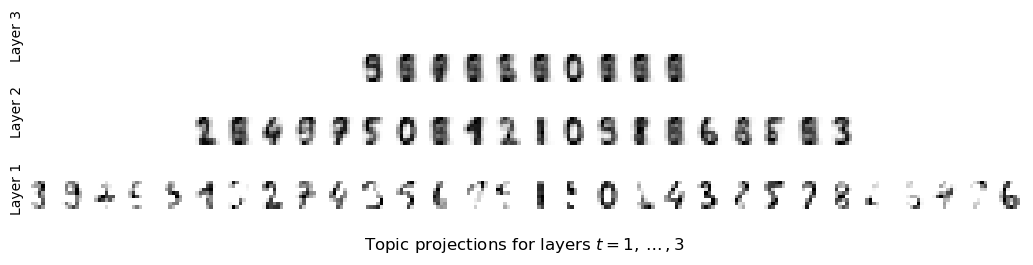

In [30]:
n_chains = 4
for i in range(n_chains):  # For each Markov chain.
    f = plt.figure(figsize=(12.5, 2.5))

    # Adjust the height ratios. The last element (e.g., 0.2) controls the height of the last row.
    # You might need to adjust these numbers based on your specific needs.
    height_ratios = [1, 1, 1, 0.15]
    gs = f.add_gridspec(4, 30, hspace=0.0, height_ratios=height_ratios)

    # Create a separate subplot for the labels
    ax_label = f.add_subplot(gs[:-1, 0])  # Exclude the last row
    ax_label.axis('off')

    # Create a separate subplot for the xlabel
    ax_xlabel = f.add_subplot(gs[-1, :])  # Include only the last row
    ax_xlabel.axis('off')

    projections = [p_31, p_21, p_1]
    for layer_nr, (n_components, feature_projec) in enumerate(
        zip(HIDDEN_LAYER_SIZES, projections)
    ):
        first_subplot_created = False

        for k, phi in enumerate(feature_projec[i]):
            idx_from = (30 - n_components) // 2 + k
            idx_to = idx_from + 1
            ax = f.add_subplot(gs[layer_nr, idx_from:idx_to])
            image = phi.reshape(8, 8)
            ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ax.spines.values():
                spine.set_visible(False)

        # Add the label to the label subplot
        ax_label.text(0, (2 - layer_nr) / 2.5 + 0.2, f"Layer {3 - layer_nr}",
                      ha='right', va='center', rotation='vertical')

    # Add the xlabel to the xlabel subplot
    ax_xlabel.text(0.5, 0, "Topic projections for layers $t=1,\dots,3$", ha='center', va='top', fontsize=12)

    # Adjust subplot parameters to fit your layout
    f.subplots_adjust(left=0.15, right=0.95, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)
    f.savefig(f'figs/digits_chain_{i+1}.pdf', bbox_inches='tight')
    f.savefig(f'figs/digits_chain_{i+1}.eps', bbox_inches='tight')
    f.savefig(f'figs/digits_chain_{i+1}.svg', bbox_inches='tight')